In [1]:
%pylab inline
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl

Populating the interactive namespace from numpy and matplotlib


In [2]:
def Solver(mu0,mu1=1,N=50,r=0.2):
    mu = np.array([mu0,mu1])
    # Create classes for defining parts of the boundaries and the interior
    # of the domain
    class Left(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0], 0.0)

    class Right(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0], 1.0)

    class Bottom(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[1], 0.0)

    class Top(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[1], 1.0)

    class Gamma0(SubDomain):
        def inside(self, x, on_boundary):
            return (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2 and (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2

    # Initialize sub-domain instances
    left   = Left()
    top    = Top()
    right  = Right()
    bottom = Bottom()
    gamma  = Gamma0()

    # Define mesh
    mesh = UnitSquareMesh(N,N)

    # Initialize mesh function for interior domains
    domains = MeshFunction("size_t", mesh, mesh.topology().dim())
    domains.set_all(0)         #domains 0 = all space
    gamma.mark(domains, 1)     #domains 1 = all gamma0

    # Initialize mesh function for boundary domains
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) #1d domains
    boundaries.set_all(0)      #boundaries 0 = all boundaries
    left.mark(boundaries, 1)   #boundaries 1 = left (Neumann)
    top.mark(boundaries, 2)    #boundaries 2 = top (Dirichlet)
    right.mark(boundaries, 3)  #boundaries 3 = right (Neumann)
    bottom.mark(boundaries, 4) #boundaries 4 = bottom (Neumann parametrized)

    # Define input data
    a1 = Constant(mu[0])  
    a2 = Constant(mu[1])

    # Define function space and basis functions
    V = FunctionSpace(mesh, "CG", 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    # Define Dirichlet boundary conditions at top and bottom boundaries
    bcs = [DirichletBC(V, 0.0, boundaries, 2)]

    # Define new measures associated with the interior domains and
    # exterior boundaries
    dx = Measure('dx', domain=mesh, subdomain_data=domains)
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

    # Separate left and right hand sides of equation
    a = inner(grad(u),grad(v))*dx(0) + inner(a1*grad(u),grad(v))*dx(1)
    L = a2*v*ds(4)
    
    # Solve problem
    u = Function(V)
    solve(a == L, u, bcs)
    plot(u)

    return [a,L,bcs,u]

AttributeError: type object 'dolfin.cpp.la.Matrix' has no attribute 'transpose'

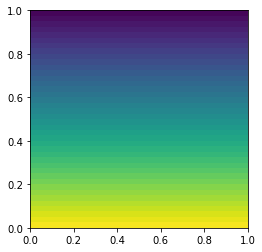

In [3]:
A = Solver(1)
print("Type de A : ",type(assemble(A[0])).transpose())
print("Type de F : ",type(A[1]))

In [4]:
def greedy_algorithm_fenics(tol, MUs, n=1, N=50):
    # En adaptant à Fenics, on a :
    # A_delta = ufl.form.Form
    # f_delta = ufl.form.Form
    # On prend un mu (au hasard) pour initialiser l'algorithme
    mu_1 = MUs[0]
    np.delete(MUs, 0)
    A_delta, f_delta, bcs, u_delta_mu_1 = Solver(mu_1)
    solve(A_delta == f_delta, u_delta_mu_1,bcs)
    plt.show()
    U_DELTA = [u_delta_mu_1.vector().get_local()]
    # On calcule tous les u_delta pour éviter de le refair dans la boucle par la suite
    for mu in MUs:
        A_delta, f_delta, bcs, u_delta = Solver(mu)
        U_DELTA.append(u_delta.vector().get_local())
    #U_DELTA = np.array([npl.solve(A_delta(mu), f_delta(mu)) for mu in MUs])
    
    # B est la matrice de changement de base de A_delta à A_rb
    B = u_delta_mu_1.vector().get_local() #np.copy(u_delta_mu_1)
    
    err = 1e10
    n=0
    while err > tol and MUs.shape[0] > 0 and n<5:
        n+=1
        eta = np.zeros(MUs.shape[0])
        
        for idx_mu, mu in enumerate(MUs):
            A_delta_mu = Solver(mu)[0]
            print(type(A_delta_mu))
            f_delta_mu = Solver(mu)[1]
            u_rb_mu = Solver(mu)[3]
        
            u_delta_mu = U_DELTA[idx_mu]
            
            # A_rb_mu @ u_rb_mu = f_rb_mu
            # A_rb_mu = B.T @ A_delta_mu @ B
            solve(B.T @ A_delta_mu @ B == B.T @ f_delta_mu, u_rb_mu)
            
            # Pour l'instant, eta(mu) = ||u_delta - u_rb||_L2
            eta[idx_mu] = npl.norm(u_delta_mu - u_rb_mu.vector().get_local(), ord=2)
        
        # On cherche la pire approximation
        idx_worst_mu = np.argmax(eta)
        
        B = np.vstack((B, U_DELTA[idx_worst_mu]))
        
        np.delete(MUs, idx_worst_mu)
        np.delete(U_DELTA,idx_worst_mu)
        
        err = eta[idx_worst_mu]
        
    return B

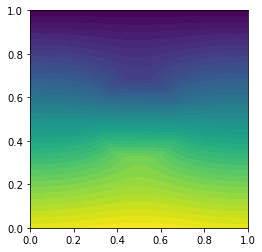

<class 'ufl.form.Form'>


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

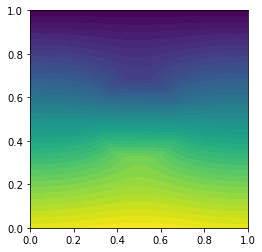

In [5]:
MUS = np.linspace(0.1,10,3)
tol = 0.1

B = greedy_algorithm_fenics(tol,MUS)
print(B)